In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
def func(x):
    return np.exp(x)*(x**2)*(1 - x)**2

In [ ]:
def ddddfunc(x):
    return np.exp(x)*(x**4 + 14*x**3 + 49*x**2 + 32*x - 12)

In [ ]:
def get_matrix_u(u):
    size = len(u)
    matrix = np.zeros((size, size), dtype='float64')
    for row in range(size):
        for col in range(size):
            matrix[row, col] = 2*u[row]*u[col]
    return np.eye(size, dtype='float64') - matrix

In [ ]:
def qr_haus(a):
    size_row, size_col = a.shape
    r = a.copy()
    qt = np.eye(size_row, dtype='float64')
    haus = np.zeros(size_row, dtype='float64')
    for col in range(size_col - 1):
        haus[col:] = r[col:, col].copy()
        haus[col] -= np.linalg.norm(r[col:, col], 2)
        haus = haus / np.linalg.norm(haus, 2)
        if np.any(haus):
            haus_matrix = get_matrix_u(haus)
            r = haus_matrix.dot(r)
            qt = haus_matrix.dot(qt)
        haus[col] = 0
    return r, qt

In [ ]:
def approx(y, arr):
    res = sum(arr[i] * y ** i for i in range(len(arr)))
    return res


def dapprox(y, arr):
    res = sum(arr[i]*i*y**(i - 1) for i in range(1, len(arr)))
    return res


def ddapprox(y, arr):
    res = sum(arr[i]*i*(i - 1)*y**(i - 2) for i in range(2, len(arr)))
    return res


def dddapprox(y, arr):
    res = sum(arr[i]*i*(i - 1)*(i - 2)*y**(i - 3) for i in range(3, len(arr)))
    return res

In [ ]:
def get_matrix():
    """Возвращает матрицы СЛАУ для первой, внутренней и последней ячеек."""
    first = np.zeros((9, 5), dtype='float64')  # Матрица для первой ячейки
    a = np.zeros((9, 5), dtype='float64')  # Матрица для внутренней ячейки
    last = np.zeros((9, 5), dtype='float64')  # Матрица для последней ячейки
    # Заполняем матрицу в левой точке y = -1. Для матриц a, last будет просто согласование условий.
    # Для матрицы first будет граничное условие.
    a[0, 0] = last[0, 0] = first[0, 0] = 1
    for i in range(1, 5):
        a[0, i] = last[0, i] = (-1) ** i - i * (-1) ** (i - 1)
        first[0, i] = (-1) ** i

    # Далее для a, last заполняется условие для вторых и третьих производных.
    # Для first будет заполняться граничное условие для первой производной.
    a[1, 0] = a[1, 1] = last[1, 0] = last[1, 1] = first[1, 0] = 0
    a[1, 2] = last[1, 2] = 2
    first[1, 1] = 1
    first[1, 2] = -2

    for i in range(3, 5):
        a[1, i] = last[1, i] = i * (i - 1) * (-1) ** (i - 2) - i * (i - 1) * (i - 2) * (-1) ** (i - 3)
        first[1, i] = i * (-1) ** (i - 1)

    # Заполняем все три матрицы в узлах коллокации.
    for i in range(2, 7):
        for t in range(4):
            a[i, t] = last[i, t] = first[i, t] = 0
        a[i, 4] = last[i, 4] = first[i, 4] = 24

    # Далее заполняются условия в точке y = 1. Для first, a заполняются условия согласования.
    # Для last заполняются краевые условия в этой точке.

    a[7, 0] = first[7, 0] = last[7, 0] = 1
    for i in range(1, 5):
        a[7, i] = first[7, i] = 1 + i
        last[7, i] = 1
    # Далее заполняем для a, first условия согласования вторых и третьих производных.
    # Для last заполням краевое условие на первую производную.
    a[8, 0] = a[8, 1] = first[8, 0] = first[8, 1] = last[8, 0] = 0
    a[8, 2] = first[8, 2] = 2
    last[8, 1] = 1
    last[8, 2] = 2
    for i in range(3, 5):
        a[8, i] = first[8, i] = i * (i - 1) + i * (i - 1) * (i - 2)
        last[8, i] = i
    return first, a, last


In [ ]:
def get_solve_first(r, qt, solve_right, length):
    """Даёт решение в первой ячейке. Length - длина ячейки, solve_right - решение справа."""
    solve = np.zeros(5, dtype='float64')
    right = np.zeros(9, dtype='float64')
    right[0] = right[1] = 0
    xc, h, hh = length / 2, length / 2, 1.0 / 3
    y = hh - 1.0
    for i in range(2, 7):
        right[i] = ddddfunc(xc + y*h)*h**4
        y += hh
    right[7] = approx(-1, solve_right) + dapprox(-1, solve_right)
    right[8] = ddapprox(-1, solve_right) + dddapprox(-1, solve_right)
    right = qt.dot(right)
    # Обратный ход Гаусса.
    for row in range(4, -1, -1):
        solve[row] = (right[row] - sum(solve[col] * r[row, col] for col in range(row + 1, 5))) / r[row, row]
    return solve

In [ ]:
def get_solve_first(r, qt, solve_right, length):
    """Даёт решение в первой ячейке. Length - длина ячейки, solve_right - решение справа."""
    solve = np.zeros(5, dtype='float64')
    right = np.zeros(9, dtype='float64')
    right[0] = right[1] = 0
    xc, h, hh = length / 2, length / 2, 1.0 / 3
    y = hh - 1.0
    for i in range(2, 7):
        right[i] = ddddfunc(xc + y*h)*h**4
        y += hh
    right[7] = approx(-1, solve_right) + dapprox(-1, solve_right)
    right[8] = ddapprox(-1, solve_right) + dddapprox(-1, solve_right)
    right = qt.dot(right)
    # Обратный ход Гаусса.
    for row in range(4, -1, -1):
        solve[row] = (right[row] - sum(solve[col] * r[row, col] for col in range(row + 1, 5))) / r[row, row]
    return solve

In [ ]:
def get_solve_mid(r, qt, solve_left, solve_right, cell, length):
    """Даёт решение в промежуточной ячейке. Cell - номер ячейки.
    Solve_left, solve_right - решения слева и справа."""
    solve = np.zeros(5, dtype='float64')
    right = np.zeros(9, dtype='float64')
    # Выписываем условия согласования слева, т.е. в точке -1.
    right[0] = approx(1, solve_left) - dapprox(1, solve_left)
    right[1] = ddapprox(1, solve_left) - dddapprox(1, solve_left)

    h, hh = length / 2, 1.0 / 3
    y = hh - 1.0
    xc = length * cell + length / 2
    for i in range(2, 7):
        right[i] = ddddfunc(xc + y * h) * h ** 4
        y += hh
    right[7] = approx(-1, solve_right) + dapprox(-1, solve_right)
    right[8] = ddapprox(-1, solve_right) + dddapprox(-1, solve_right)

    right = qt.dot(right)
    # Обратный ход Гаусса.
    for row in range(4, -1, -1):
        solve[row] = (right[row] - sum(solve[col] * r[row, col] for col in range(row + 1, 5))) / r[row, row]
    return solve


In [ ]:
def get_solve_last(r, qt, solve_left, length):
    """Даёт решение в последней ячейке. Length - длина ячейки, solve_left - решение слева."""
    solve = np.zeros(5, dtype='float64')
    right = np.zeros(9, dtype='float64')
    # Выписываем условия согласования слева, т.е. в точке -1.
    right[0] = approx(1, solve_left) - dapprox(1, solve_left)
    right[1] = ddapprox(1, solve_left) - dddapprox(1, solve_left)
    h, hh = length / 2, 1.0 / 3
    y = hh - 1.0
    xc = 1 - h
    for i in range(2, 7):
        right[i] = ddddfunc(xc + y * h) * h ** 4
        y += hh
    right[7] = right[8] = 0
    right = qt.dot(right)
    # Обратный ход Гаусса.
    for row in range(4, -1, -1):
        solve[row] = (right[row] - sum(solve[col] * r[row, col] for col in range(row + 1, 5))) / r[row, row]
    return solve

In [ ]:
def get_info(cell, coef, length):
    """Возвращает относительную и абсолютную погрешности. Также возврощает 3 списка для рисования графиков,
    cell - количество ячеек."""
    err = den = 0
    hh, h = 2.0 / 99, length / 2
    lst_x = []
    lst_func = []
    lst_appr = []
    for number in range(cell):
        y, xc = -1 + hh, number * length + h
        for i in range(99):
            lst_x.append(xc + y*h)
            lst_func.append(func(lst_x[-1]))
            lst_appr.append(approx(y, coef[number]))

            test = np.abs(lst_func[-1] - lst_appr[-1])
            if test > err:
                err = test

            test = np.abs(lst_func[-1])
            if test > den:
                den = test
            y += hh
    return err / den, err, lst_x, lst_func, lst_appr

In [ ]:
def all_plot(lst_x, lst_f, lst_appr, cell):
    plt.plot(lst_x, lst_f, label='Приближаемая функция')
    plt.plot(lst_x, lst_appr, label= 'Аппроксимант')
    plt.legend()
    plt.xlabel('x', fontsize=11)
    plt.ylabel('y', fontsize=11)
    plt.title('Результаты аппроксимации при K = %i' % cell)
    plt.grid()
    plt.show()

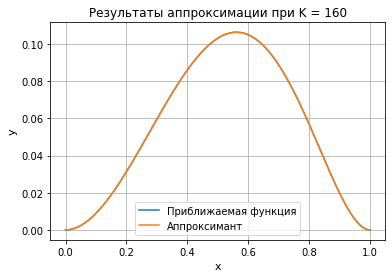

2.607614005598058e-06
2.453286260818171e-05
56414

 

Порядок абсолютной погрешности: 2.009587
Порядок относительной погрешности: 2.008335


In [18]:
left, mid, dexter = get_matrix()
R_left, Qt_left = qr_haus(left)
R_mid, Qt_mid = qr_haus(mid)
R_dex, Qt_dex = qr_haus(dexter)
pseudo_err = 10**(-12)
err_old = 1
rel_err_old = 1
lst_fo_pse = []
lst_fo_it = []


for k in 160,:
    coef_new = np.full((k, 5), 0.4)
    coef_old = np.full((k, 5), 0.4)
    step = 1.0 / k  # длина ячейки
    count = 0  # число итераций
    start_time = time.time()
    while True:
        coef_new[0] = get_solve_first(R_left, Qt_left, coef_old[1], step)
        for j in range(1, k - 1):
            coef_new[j] = get_solve_mid(R_mid, Qt_mid, coef_new[j - 1], coef_old[j + 1], j, step)
        coef_new[k - 1] = get_solve_last(R_dex, Qt_dex, coef_new[k - 2], step)
        lst_fo_pse.append(np.max(np.abs(coef_new - coef_old)))
        lst_fo_it.append(count + 1)
        if lst_fo_pse[-1] < pseudo_err:
            break
        coef_old = coef_new.copy()
        count += 1
    rel_err, err_new, data_x, data_f, data_ap = get_info(k, coef_new, step)
    all_plot(data_x, data_f, data_ap, k)
    err_old, rel_err_old = err_new, rel_err
    print(err_new)
    print(rel_err)
    print(count)
    # print(time.time() - start_time)
    print('\n \n')
    print('Порядок абсолютной погрешности: %f' % abs(np.log2(0.0000105 / err_new)), end='\n')
    print('Порядок относительной погрешности: %f' % abs(np.log2(0.0000987 / rel_err)), end='\n')



Обусловленность матрицы СЛАУ в первой ячейке: 69.765386
Обусловленность матрицы СЛАУ в промежуточной ячейке: 121.053755
Обусловленность матрицы СЛАУ в последней ячейке: 69.765386


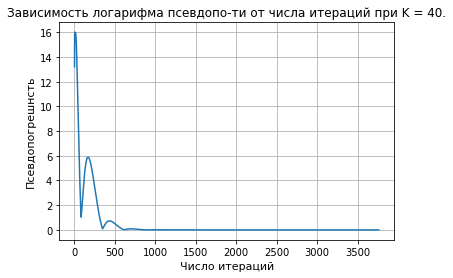

In [15]:
print('Обусловленность матрицы СЛАУ в первой ячейке: %f' % np.linalg.cond(left, 2))
print('Обусловленность матрицы СЛАУ в промежуточной ячейке: %f' % np.linalg.cond(mid, 2))
print('Обусловленность матрицы СЛАУ в последней ячейке: %f' % np.linalg.cond(dexter, 2))

lst_fo_pse = np.log10(np.array(lst_fo_pse))

plt.plot(lst_fo_it, lst_fo_pse)
plt.xlabel('Число итераций', fontsize=11)
plt.ylabel('Псевдопогрешнсть', fontsize=11)
plt.title('Зависимость логарифма псевдопо-ти от числа итераций при K = 40.')
plt.grid()
plt.show()
